<a href="https://colab.research.google.com/github/tbazzi/Data-Science---Fullstack-Bootcamp/blob/master/S6_3_2_Segmentation_with_FastAi_SOLUTIONS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentation with FastAi

Avec les images, nous pouvons aussi faire en sorte de classer chaque pixel pour savoir à quel objet il appartient. Par exemple, un pixel peut faire partie de l'objet : "feu de signalisation". FastAI gère extrêmement bien ce genre de problématique. Voyons dans cet exercice comment

1. Importez le module ```fastai.vision```

In [0]:
from fastai.vision import *

2. Nous allons utiliser le dataset ```URLs.CAMVID_TINY``` pour la suite. Importez le dans une variable ```camvid```

In [0]:
camvid = untar_data(URLs.CAMVID_TINY)

3. Regardez ce que contient votre variable 

In [0]:
list(camvid.glob("*"))

[PosixPath('/root/.fastai/data/camvid_tiny/codes.txt'),
 PosixPath('/root/.fastai/data/camvid_tiny/labels'),
 PosixPath('/root/.fastai/data/camvid_tiny/images')]

4. Regardez ce que contient le dossier images (affichez simplement les 5 premiers éléments )

In [0]:
path = camvid/"images"
list(path.glob("*"))[:5]

[PosixPath('/root/.fastai/data/camvid_tiny/images/0006R0_f03180.png'),
 PosixPath('/root/.fastai/data/camvid_tiny/images/0016E5_06810.png'),
 PosixPath('/root/.fastai/data/camvid_tiny/images/0016E5_08001.png'),
 PosixPath('/root/.fastai/data/camvid_tiny/images/Seq05VD_f04530.png'),
 PosixPath('/root/.fastai/data/camvid_tiny/images/0006R0_f03720.png')]

5. Regardez maintenant ce que contient le fichier ```codes.txt```

In [0]:
import pandas as pd 
codes = pd.read_csv(camvid/"codes.txt", header=None)
codes.tail()

,0
27,Truck_Bus
28,Tunnel
29,VegetationMisc
30,Void
31,Wall


6. Regardez maintenant le dossier ```labels```

In [0]:
path_labels = camvid/"labels"
list(path_labels.glob("*"))[:5]

[PosixPath('/root/.fastai/data/camvid_tiny/labels/0016E5_08089_P.png'),
 PosixPath('/root/.fastai/data/camvid_tiny/labels/0016E5_06300_P.png'),
 PosixPath('/root/.fastai/data/camvid_tiny/labels/0001TP_008670_P.png'),
 PosixPath('/root/.fastai/data/camvid_tiny/labels/0001TP_009930_P.png'),
 PosixPath('/root/.fastai/data/camvid_tiny/labels/0016E5_07979_P.png')]

7. Il semblerait que nos labels aient presque le même nom que nos photos. Il va falloir apprendre à gérer cela pour créer notre databunch. Il va falloir créer une fonction qui va nous permettre de tirer le noms des labels. Apprenons à le faire pas à pas. Essayons d'abord de comprendre comment nous pouvons construire la chose. 

Pour cela, construisez un DataFrame qui aura pour colonne : ```paths```. Les lignes contiendront chacune le chemin vers les images du dataset  ```path.glob("*")```

In [0]:
# Voir comment itérer sur un chemin 

import pandas as pd 

df=pd.DataFrame({"paths": list(path.glob("*"))})

In [0]:
df.head()

,paths
0,/root/.fastai/data/camvid_tiny/images/0006R0_f...
1,/root/.fastai/data/camvid_tiny/images/0016E5_0...
2,/root/.fastai/data/camvid_tiny/images/0016E5_0...
3,/root/.fastai/data/camvid_tiny/images/Seq05VD_...
4,/root/.fastai/data/camvid_tiny/images/0006R0_f...


8. Regardez une image de votre dataset, pour cela, utilisez ```open_image()``` qui prendra comme argument un chemin que vous pouvez prendre dans votre dataset. Vous aurez aussi besoin d'utiliser 

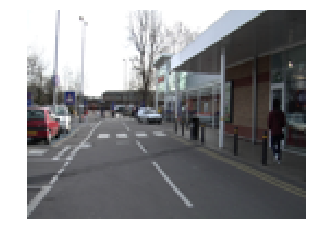

In [0]:
# See an image
open_img = df.paths[0]
img = open_image(open_img)
img.show(figsize=(5,5))

9. Regardez maintenant un label, opérez les mêmes manipulations pour voir le premier label de votre dataset 

In [0]:
# Voir comment itérer sur un chemin 

import pandas as pd 

df_labels=pd.DataFrame({"paths": list(path_labels.glob("*"))})
df_labels.head()

,paths
0,/root/.fastai/data/camvid_tiny/labels/0016E5_0...
1,/root/.fastai/data/camvid_tiny/labels/0016E5_0...
2,/root/.fastai/data/camvid_tiny/labels/0001TP_0...
3,/root/.fastai/data/camvid_tiny/labels/0001TP_0...
4,/root/.fastai/data/camvid_tiny/labels/0016E5_0...


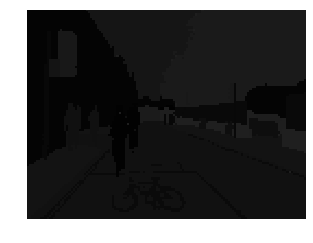

In [0]:
# See an image
open_img = df_labels.paths[0]
img = open_image(open_img)
img.show(figsize=(5,5))

10. Il semblerait que les labels et les images ne correspondent pas par leur position dans le dataset. Essayez de trouver autre chose qui puisse faire matcher l'image avec son masque 

In [0]:
print(list(path.glob("*"))[:5])
print(list(path_labels.glob("*"))[:5])

[PosixPath('/root/.fastai/data/camvid_tiny/images/0006R0_f03180.png'), PosixPath('/root/.fastai/data/camvid_tiny/images/0016E5_06810.png'), PosixPath('/root/.fastai/data/camvid_tiny/images/0016E5_08001.png'), PosixPath('/root/.fastai/data/camvid_tiny/images/Seq05VD_f04530.png'), PosixPath('/root/.fastai/data/camvid_tiny/images/0006R0_f03720.png')]
[PosixPath('/root/.fastai/data/camvid_tiny/labels/0016E5_08089_P.png'), PosixPath('/root/.fastai/data/camvid_tiny/labels/0016E5_06300_P.png'), PosixPath('/root/.fastai/data/camvid_tiny/labels/0001TP_008670_P.png'), PosixPath('/root/.fastai/data/camvid_tiny/labels/0001TP_009930_P.png'), PosixPath('/root/.fastai/data/camvid_tiny/labels/0016E5_07979_P.png')]


11. Les masks (labels) et les images matchent par rapport à leur noms ! Il va falloir trouver un moyen de trouver le bon mask de l'image de notre dataset. Pouvez vous penser à quelque chose ? 

Pour vous aider, appuyez vous sur la librairie [Pathlib](https://docs.python.org/3/library/pathlib.html#general-properties) 

Regardez particulièrement : 

* [PurePath.stem](https://docs.python.org/3/library/pathlib.html?highlight=stem#pathlib.PurePath.stem)
* [PurePath.suffix](https://docs.python.org/3/library/pathlib.html?highlight=stem#pathlib.PurePath.suffix)

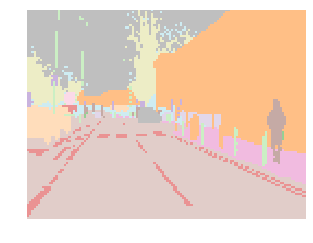

In [0]:
for item in list(path_labels.glob("*")):
  if item == camvid/"labels"/"{}_P{}".format(df.paths[0].stem, df.paths[0].suffix):
     open_mask(item).show(figsize=(5,5))

12. Nous allons nous servir de la même technique pour faire matcher nos labels avec nos images sur notre DataBunch. Créez une fonction lamdba qui va prendre le *stem* et le *suffix* de chacun de vos chemins. 

In [0]:
get_y_labels = lambda x: camvid/"labels"/f'{x.stem}_P{x.suffix}'

13. Créez maintenant un DataBunch 

In [0]:
data = (SegmentationItemList.from_folder(camvid/"images")
        .split_by_rand_pct()
        .label_from_func(get_y_labels, classes=codes)
        .transform(get_transforms(), tfm_y=True, size=224)
        .databunch(bs=16, path=camvid)
        .normalize(imagenet_stats)
       )

14. Regardez un batch de données 

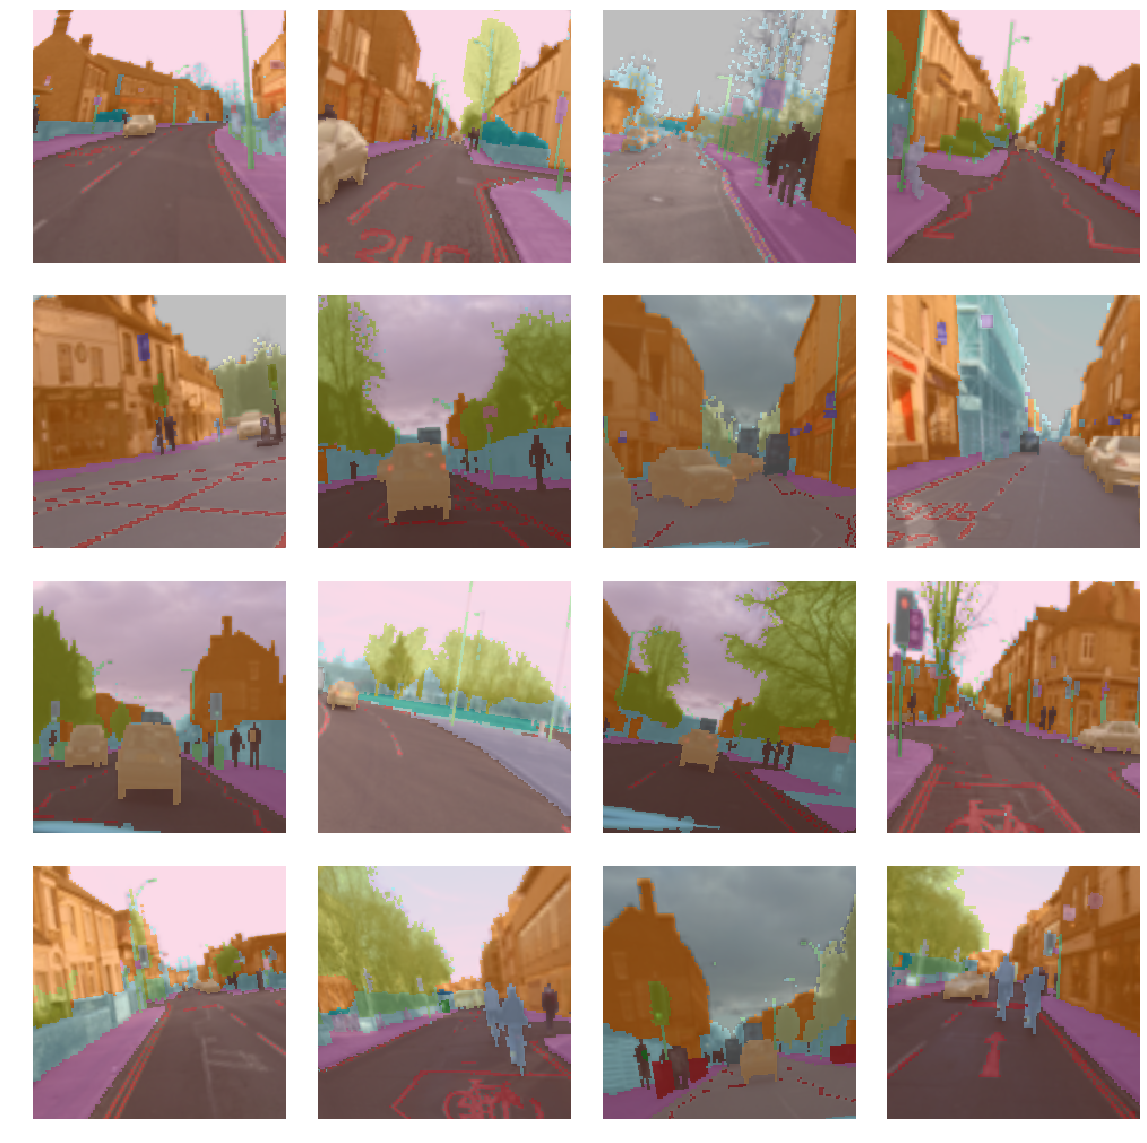

In [0]:
data.show_batch()

15. Regardez un item de votre DataBunch via ```data.open(data.item[idx])```

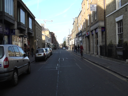

In [0]:
data.open(data.items[0])

16. Nous allons bientôt pouvoir créer notre modèle, cependant, nous devons construire une metric qui va nous permettre d'évaluer notre modèle. Ajoutez la fonction suivante : 

``` 
name2id = {k:v for v, k in zip(list(codes.index), codes.iloc[:, 0])}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()
```

In [0]:
name2id = {k:v for v, k in zip(list(codes.index), codes.iloc[:, 0])}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

17. Créez un modèle qui va permettre de prédire où se trouve chaque pixel dans l'image. Cependant cette fois, nous allons utiliser un autre type de modèle qu'un CNN. Nous allons utiliser un ```unet_learner``` qui prendra un resnet18 comme architecture et ```acc_camvid``` comme metric

[Plus d'information sur Unet](https://docs.fast.ai/vision.models.unet.html)

In [0]:
learn = unet_learner(data, models.resnet18, metrics =acc_camvid)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 85497379.23it/s]


In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,acc_camvid,time
0,3.944586,2.540106,0.362356,04:29
1,5.262311,2.348426,0.360993,04:40
2,4.133852,2.023285,0.376422,04:31
3,3.501275,1.916969,0.511521,04:32


18. Faisons un peu de fine tuning et trouvons notre learning rate optimal 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.37E-03


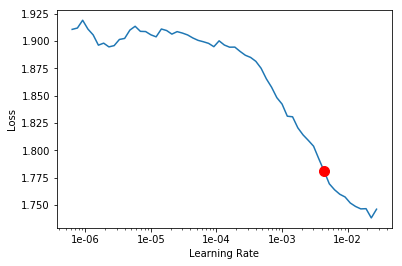

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion = True)

19. *unfreezez* votre modèle et re-entrainez le avec le learning rate idéal 

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(4, 4.37E-03)

epoch,train_loss,valid_loss,acc_camvid,time
0,2.172597,2.140237,0.374627,04:40
1,3.807972,2.733495,0.332058,04:48
2,3.275939,29.576694,0.234138,04:39
3,2.902584,4.162159,0.361117,04:41


20. Les résultats ne sont pas encore très satisfaisants, retentons le processus 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.63E-03


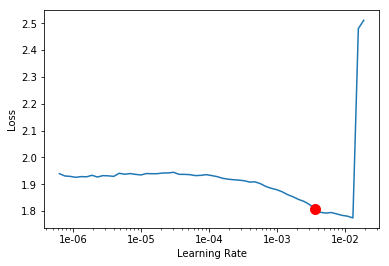

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(5, 3.63E-03)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.331744,1.492267,0.569086,04:40
1,1.485024,2.128572,0.476755,04:40
2,1.580601,16.401196,0.394537,04:40
3,1.566609,1.410588,0.663427,04:38
4,1.524472,1.360560,0.672086,04:40


21. Les résultats sont maintenant largement meilleurs, regardez les résultats de votre modèle 

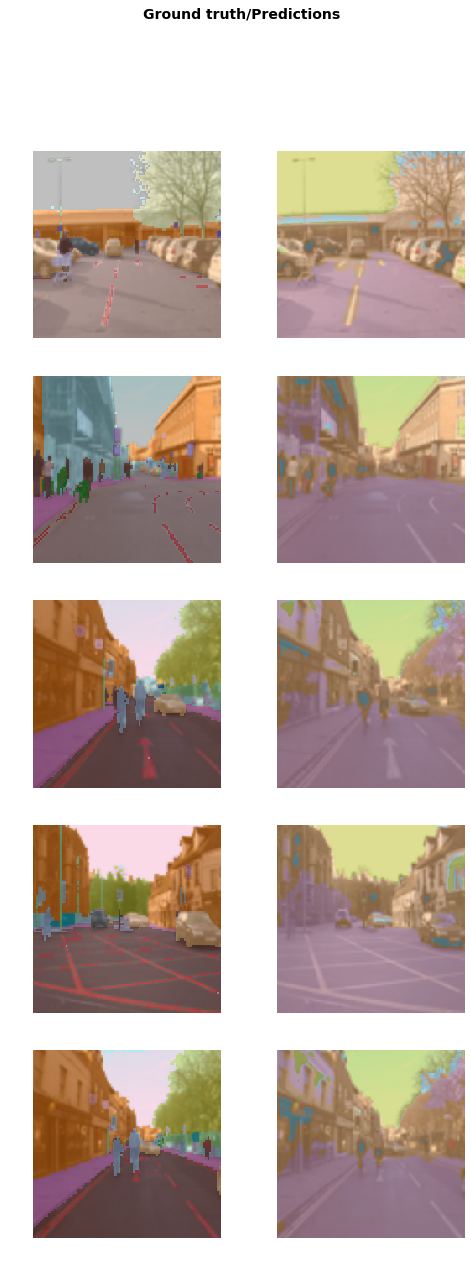

In [0]:
learn.show_results()